# RL and Advanced DL. Homework #3
<br>

Task text:
<br>

https://docs.google.com/document/d/1DIBYLQ755w7z06IslSVzFf3gyiKd8077ZYyzD5TU8ug
<br>

In [2]:
import os
from PIL import Image
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# import torchvision.transforms as transforms
# from torch.autograd import Variable
# from torchvision.utils import save_image

# import torchvision.datasets as datasets
from torchvision.utils import make_grid

sns.set_style("whitegrid")
# sns.set_palette("colorblind")
# palette = sns.color_palette()
# figsize = (17, 8)
# legend_fontsize = 16

### Load data, make Datasets and Dataloaders

In [ ]:
%%capture
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -zxvf facades.tar.gz

In [ ]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, phase="train", transform=None):
        self.transform = transform
        self.phase = phase
        self.img_dir = img_dir
        self.img_paths = [img_name.split('.')[0] for img_name in os.listdir(f"{self.img_dir}/{self.phase}")]
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = np.asarray(Image.open(f'{self.img_dir}/{self.phase}/{self.img_paths[index]}.jpg'))
        # (256, 512)
        h, w, _ = img.shape
        image = img[:, :w // 2, :]
        label = img[:, w // 2:, :]
        if self.transform:
            pass
        image = self.to_tensor(image.copy())
        label = self.to_tensor(label.copy())
        return image, label

In [ ]:
train_dataset = PairDataset(img_dir="/facades", phase="train")
val_dataset = PairDataset(img_dir="/facades", phase="val")
test_dataset = PairDataset(img_dir="/facades", phase="test")

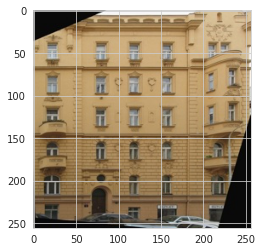

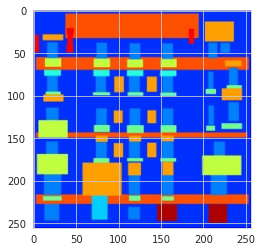

In [ ]:
image, label = train_dataset[10]
plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(label.permute(1, 2, 0))
plt.show()

In [ ]:
BATCH_SIZE = 10
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## I. pix2pix

In [ ]:
class Pix2Pix(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self):
        pass

In [ ]:
# t = torch.rand(3, 32, 8, 8)
# m = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
# m2 = nn.UpsamplingNearest2d(scale_factor=2)
# y = m(t)
# print(y.shape)
# y = m2(y)
# print(y.shape)

torch.Size([3, 16, 16, 16])
torch.Size([3, 16, 32, 32])


In [ ]:
# torch.cat([t, t.clone()], dim=1).shape

torch.Size([3, 64, 8, 8])

In [ ]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, in_channels=3, out_channels=3, n_blocks=8, min_filters=64, max_filters=512, dropout=0.1):
    # , ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):

        """Construct a Unet generator
        Parameters:
            in_nc / input_nc (int)  -- the number of channels in input images
            out_nc / output_nc (int) -- the number of channels in output images
            n_blocks
            max_filters
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super().__init__()
        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=min_filters, kernel_size=3, padding=1),
            nn.AvgPool2d(kernel_size=2),
            # nn.BatchNorm2d(min_filters),
            nn.ReLU(),
        )

        self.last_block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2*min_filters, out_channels=out_channels, 
                kernel_size=3, stride=2, padding=1, output_padding=1,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.Sigmoid(),
        )

        unet_block = nn.Conv2d(in_channels=max_filters, out_channels=2*max_filters, kernel_size=3, padding=1) 

        # [64, 128, 256, 512, 512, 512]
        outer_nc_list = [min(max_filters, min_filters * (1 << i)) for i in range(n_blocks - 1)]
        # [128, 256, 512, 512, 512, 512]
        inner_nc_list = [min(max_filters, 2 * min_filters * (1 << i)) for i in range(n_blocks - 1)]
        
        for outer_nc, inner_nc in zip(reversed(outer_nc_list), reversed(inner_nc_list)):
            unet_block = UnetSkipConnectionBlock(outer_nc=outer_nc, inner_nc=inner_nc, inner_block=unet_block)
        self.unet = unet_block

    def forward(self, inputs):
        # inputs ~ (bs, in_channels, h, w)
        x = self.first_block(inputs)
        x = self.unet(x)
        outputs = self.last_block(x)
        return outputs


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """
    def __init__(self, outer_nc, inner_nc, inner_block=None, dropout=0.1):
        super().__init__()
        self.inner_block = inner_block
        self.conv_down = nn.Sequential(
            nn.Conv2d(in_channels=outer_nc, out_channels=inner_nc, kernel_size=3, padding=1),
            nn.AvgPool2d(kernel_size=2),                            
        )
        self.conv_up = nn.ConvTranspose2d(
            in_channels=2*inner_nc, out_channels=outer_nc, 
            kernel_size=3, stride=2, padding=1, output_padding=1,
        )
        # Conv2d(in_channels=outer_nc, out_channels=inner_nc, kernel_size=3, padding=1)
        # self.dim_up = nn.UpsamplingNearest2d(scale_factor=2)

        self.bn_down = nn.BatchNorm2d(inner_nc)
        self.bn_up = nn.BatchNorm2d(outer_nc)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        print(f"in: {inputs.shape}")
        # inputs ~ (bs, outer_nc, h, w)
        x = self.conv_down(inputs)
        x = self.bn_down(x)
        x = self.relu(x)
        # x ~ (bs, inner_nc, h // 2, w // 2)
        x = self.inner_block(x)
        # inputs ~ (bs, 2 * inner_nc, h // 2, w // 2)
        # when identity n_filters = 2 * max_filters
        x = self.conv_up(x)
        x = self.bn_up(x)
        x = self.relu(x)
        outputs = torch.cat([x, inputs], dim=1)
        # outputs ~ (bs, 2 * outer_nc, h, w)
        print(f"in: {outputs.shape}")
        return outputs
        

    # def __init__(self, outer_nc, inner_nc, input_nc=None,
    #              submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
    #     """Construct a Unet submodule with skip connections.
    #     Parameters:
    #         outer_nc (int) -- the number of filters in the outer conv layer
    #         inner_nc (int) -- the number of filters in the inner conv layer
    #         input_nc (int) -- the number of channels in input images/features
    #         submodule (UnetSkipConnectionBlock) -- previously defined submodules
    #         outermost (bool)    -- if this module is the outermost module
    #         innermost (bool)    -- if this module is the innermost module
    #         norm_layer          -- normalization layer
    #         use_dropout (bool)  -- if use dropout layers.
    #     """
    #     super(UnetSkipConnectionBlock, self).__init__()
    #     self.outermost = outermost
    #     if type(norm_layer) == functools.partial:
    #         use_bias = norm_layer.func == nn.InstanceNorm2d
    #     else:
    #         use_bias = norm_layer == nn.InstanceNorm2d
    #     if input_nc is None:
    #         input_nc = outer_nc
    #     downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
    #                          stride=2, padding=1, bias=use_bias)
    #     downrelu = nn.LeakyReLU(0.2, True)
    #     downnorm = norm_layer(inner_nc)
    #     uprelu = nn.ReLU(True)
    #     upnorm = norm_layer(outer_nc)

    #     if outermost:
    #         upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
    #                                     kernel_size=4, stride=2,
    #                                     padding=1)
    #         down = [downconv]
    #         up = [uprelu, upconv, nn.Tanh()]
    #         model = down + [submodule] + up
    #     elif innermost:
    #         upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
    #                                     kernel_size=4, stride=2,
    #                                     padding=1, bias=use_bias)
    #         down = [downrelu, downconv]
    #         up = [uprelu, upconv, upnorm]
    #         model = down + up
    #     else:
    #         upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
    #                                     kernel_size=4, stride=2,
    #                                     padding=1, bias=use_bias)
    #         down = [downrelu, downconv, downnorm]
    #         up = [uprelu, upconv, upnorm]

    #         if use_dropout:
    #             model = down + [submodule] + up + [nn.Dropout(0.5)]
    #         else:
    #             model = down + [submodule] + up

    #     self.model = nn.Sequential(*model)

    # def forward(self, x):
    #     if self.outermost:
    #         return self.model(x)
    #     else:   # add skip connections
    #         return torch.cat([x, self.model(x)], 1)

In [ ]:
u = UnetGenerator()
t = torch.rand(10, 3, 256, 256)
y = u(t)
y.shape

in: torch.Size([10, 64, 128, 128])
in: torch.Size([10, 128, 64, 64])
in: torch.Size([10, 256, 32, 32])
in: torch.Size([10, 512, 16, 16])
in: torch.Size([10, 512, 8, 8])
in: torch.Size([10, 512, 4, 4])
in: torch.Size([10, 512, 2, 2])
in: torch.Size([10, 1024, 2, 2])
in: torch.Size([10, 1024, 4, 4])
in: torch.Size([10, 1024, 8, 8])
in: torch.Size([10, 1024, 16, 16])
in: torch.Size([10, 512, 32, 32])
in: torch.Size([10, 256, 64, 64])
in: torch.Size([10, 128, 128, 128])


torch.Size([10, 3, 256, 256])

In [ ]:
class PatchGAN(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, in_channels, min_filters=64, n_layers=3):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super().__init__()

        n_layers = min(n_layers, 8)
        first_block = nn.Sequential(
            nn.Conv2d(in_channels, min_filters, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            # nn.LeakyReLU(0.2, True),
        )
        block_list = [first_block]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            block = nn.Sequential(
                nn.Conv2d(min_filters * nf_mult_prev, min_filters * nf_mult, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(min_filters * nf_mult),
                nn.ReLU(),
                # nn.LeakyReLU(0.2, True)
            )
            block_list.append(block)
        
        last_block = nn.Conv2d(min_filters * nf_mult, 1, kernel_size=3, stride=1, padding=1)
        block_list.append(last_block)
        self.block_list = nn.ModuleList(block_list)

    def forward(self, x):
        """Standard forward."""
        for module in self.block_list:
            print(x.shape)
            x = module(x)
        return x

In [ ]:
# u = PatchGAN(in_channels=6)
# t = torch.rand(10, 6, 256, 256)
# y = u(t)
# y.shape

torch.Size([10, 6, 256, 256])
torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 64, 64])
torch.Size([10, 256, 32, 32])


torch.Size([10, 1, 32, 32])

## II. CycleGAN